<a href="https://colab.research.google.com/github/ZsofiaK/masterthesis/blob/main/Implementation/Pipeline/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification (binary action recognition)

## Setting up requirements

In [1]:
# Setting up dictionaries for later ease of use.
dataset_dict = {'fishClips' : 'Fish clips', 'AK-fish' : 'AK fish'}

input_sizes_dict = {'dinov2-vits14-clf' : 384, 'dinov2-vitg14-clf' : 1536}

In [2]:
# Set the dataset, model and embedding specifics for the classification.

dataset_name = 'AK-fish'

dataset_dir = dataset_dict[dataset_name]

image_size = 448    # The size of the embedded images.

frame_selection_method = 'motionAbsdiff_10'

embedding_method = 'dinov2-vits14-clf'

clf_name = 'ShallowNetwork'

val_score = 'roc_auc'  # Score to use during cross-validation.

seed = 23   # For reproducability in pseudo-randomness.

nr_frames = int(frame_selection_method.split('_')[-1])

input_size = input_sizes_dict[embedding_method] * nr_frames   # Size of the input vectors (embeddings).

In [3]:
# Setting up parameters for cross validation.

# Number of folds to use.
cv_folds = 3

# Parameter grids to use for the models.
param_grid = { 'ShallowNetwork': {
    'layers': [0, 1, 2, 3],
    'dropout_rate': [0.0, 0.25, 0.5],
    'learning_rate': [0.01, 0.001, 0.0001],
    'pos_threshold' : [0.1, 0.15, 0.2, 0.5],  # Threshold for turning sigmoid prediction to binary label.
    'epochs': [50],
    'batch_size': [32]
}
}

In [4]:
# Setting up folder to save outputs.
import os

output_dir = 'Output'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Mount Drive.
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Specify data source
data_source = f"/content/drive/My Drive/UvA/M Thesis/Data/{dataset_dir}"

# Specify directory to copy to
data_dir = f"/content/{dataset_dir}"

In [10]:
# Copy the folder to destination
import shutil
shutil.copytree(data_source, data_dir)

'/content/AK fish'

## Loading data

In [11]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output

In [12]:
# Load video embeddings and labels
embeddings_dir = f'{data_dir}/Embeddings/{frame_selection_method}/{embedding_method}/{image_size}'
clips_csv_path = f'{data_dir}/clips.csv'

clips_df = pd.read_csv(clips_csv_path)

nr_clips = len(clips_df)
progress = 0

X_train = []  # Embeddings
X_test = []
y_train = []  # Labels
y_test = []

video_names_train = []  # Video names for saving predictions
video_names_test = []

not_found_embeddings = []

for index, row in clips_df.iterrows():
    video_name = row['video'].replace('.mp4', '')
    label = row['label']

    embedding_path = os.path.join(embeddings_dir, f"{video_name}.npy")

    if os.path.exists(embedding_path):
        embedding = np.load(embedding_path)

        if row['type'] == 'train':
          X_train.append(embedding)
          y_train.append(label)
          video_names_train.append(video_name)

        elif row['type'] == 'test':
          X_test.append(embedding)
          y_test.append(label)
          video_names_test.append(video_name)

    else:
      not_found_embeddings.append(video_name)

    progress += 1

    clear_output(wait=True)
    print(f'Number of videos: {nr_clips}')
    print(f'Progress: {progress/nr_clips * 100:.2f}%')

Number of videos: 887
Progress: 100.00%


In [13]:
# Check if all embeddings were successfully loaded.

if len(not_found_embeddings) > 0:
  print(f' WARNING: Failed to find embeddings for {len(not_found_embeddings)} videos.')

else:
  print('Success! All embeddings read.')

Success! All embeddings read.


In [14]:
# Check if all embeddings have the required input size and remove the ones which do not.
X_train_original = X_train.copy()
X_test_original = X_test.copy()
y_train_original = y_train.copy()
y_test_original = y_test.copy()
video_names_train_original = video_names_train.copy()
video_names_test_original = video_names_test.copy()

X_train = []
X_test = []
y_train = []
y_test = []
video_names_train = []
video_names_test = []

for i, array in enumerate(X_train_original):
  if len(array) == input_size:
    X_train.append(array)
    y_train.append(y_train_original[i])
    video_names_train.append(video_names_train_original[i])

for i, array in enumerate(X_test_original):
  if len(array) == input_size:
    X_test.append(array)
    y_test.append(y_test_original[i])
    video_names_test.append(video_names_test_original[i])

In [15]:
# Check if any embeddings had to be removed.
print(f'{len(X_train_original)-len(X_train)} embeddings were removed from training set due to incorrect embedding size.')
print(f'{len(X_test_original)-len(X_test)} embeddings were removed from test set due to incorrect embedding size.')

4 embeddings were removed from training set due to incorrect embedding size.
2 embeddings were removed from test set due to incorrect embedding size.


In [16]:
# Converting to numpy.
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [18]:
# Handle class imbalance through class weights
all_labels = np.concatenate((y_train, y_test))

class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print('Class weights:')
print(class_weights_dict)

Class weights:
{0: 0.550625, 1: 5.438271604938271}


## Cross-validate model

In [19]:
## FUNCTIONS FOR MODEL CROSS-VALIDATION.

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_auc_score
from IPython.display import clear_output

def create_shallow_network(input_dim, hidden_layers, dropout_rate, learning_rate):
    model = Sequential()

    # Dense input layer with ReLu
    model.add(Dense(10, input_dim=input_dim, activation='relu'))

    # Dense hidden layers with ReLu and dropout
    for _ in range(hidden_layers):
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Dense output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

def crossval_shallow_network(n_splits, input_dim, X, y, params_grid, \
                             val_score = 'accuracy', verbose=False):

  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  # Set up best result tracker for grid search loop
  best_score = 0

  best_params = {}

  # Calculate number of runs for progress monitoring.
  total_runs = 1

  for params in params_grid.values():
    total_runs *= len(params)

  total_runs *= n_splits

  progress = 0

  # Grid search loop
  for hidden_layers in params_grid['layers']:
      for dropout_rate in params_grid['dropout_rate']:
          for learning_rate in params_grid['learning_rate']:

            scores = {threshold : [] for threshold in params_grid['pos_threshold']}

            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Create and fit the model
                model = create_shallow_network(input_dim, hidden_layers, \
                                                dropout_rate, learning_rate)

                model.fit(X_train, y_train, epochs=10, verbose=0)

                # Sigmoid output
                y_pred_raw = model.predict(X_test)

                # Predicted labels based on sigmoid output
                for threshold in params_grid['pos_threshold']:
                  y_pred = (y_pred_raw > threshold).astype(int).squeeze()

                  # Calculate performance based on selected score
                  if val_score == 'accuracy':
                    score = accuracy_score(y_test, y_pred)

                  elif val_score == 'recall':
                    score = recall_score(y_test, y_pred)

                  elif val_score == 'f1_score':
                    score = f1_score(y_test, y_pred)

                  elif val_score == 'roc_auc':
                    score = roc_auc_score(y_test, y_pred_raw)

                  else:
                    print(f'ERROR: unexpected validation score {val_score}.')
                    print('Select one of: accuracy, recall, f1_score')

                  scores[threshold].append(score)

                  progress += 1

                  clear_output(wait=True)
                  print(f'Cross-validation progress: {progress / total_runs * 100:.2f}%')

                # Best average score across all folds
                best_threshold = max(scores, key=lambda thr: np.mean(scores[thr]))
                best_average_score = np.mean(scores[best_threshold])

                # Check if current model settings beat the current best
                if best_average_score > best_score:
                    best_score = best_average_score
                    best_params = {'hidden_layers': hidden_layers,
                                  'dropout_rate': dropout_rate,
                                  'learning_rate': learning_rate,
                                  'pos_threshold': best_threshold}

  # Print best parameters and their score
  if verbose:
    print(f"\nBest Score: {best_score:.4f}")
    print("Best Parameters:", best_params)

  return best_params

In [20]:
# Setting up model dictionary for ease of reuse.
# Only models which do not need cross-validation are included in this.
# Models with cross-validation are handled on an individual basis.

models_dict = {
    'LogisticRegression' : LogisticRegression(max_iter=1000, class_weight=class_weights_dict),
    'SVC-Linear' : SVC(class_weight='balanced', kernel='linear')
    }

# Models which do not need cross-validation.
no_cross_val = list(models_dict.keys())

In [21]:
# Selecting model (with potential cross validation).
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# If model requires cross-validation.
if clf_name not in no_cross_val:
  if clf_name == 'ShallowNetwork':
    best_params = crossval_shallow_network(cv_folds, input_size, X_train, \
                                           y_train, param_grid['ShallowNetwork'],\
                                           val_score = val_score, verbose=True)

    model = create_shallow_network(input_size, best_params['hidden_layers'], \
                                 best_params['dropout_rate'], best_params['learning_rate'])

# If model does not require cross-validation.
else:
  model = models_dict[clf_name]

Cross-validation progress: 100.00%

Best Score: 0.9212
Best Parameters: {'hidden_layers': 3, 'dropout_rate': 0.25, 'learning_rate': 0.001, 'pos_threshold': 0.1}


In [22]:
# Train model on the training set.
model.fit(X_train, y_train)

23/23 [==============================] - 2s 5ms/step - loss: 0.4147 - accuracy: 0.8780


23/23 [==============================] - 0s 2ms/step


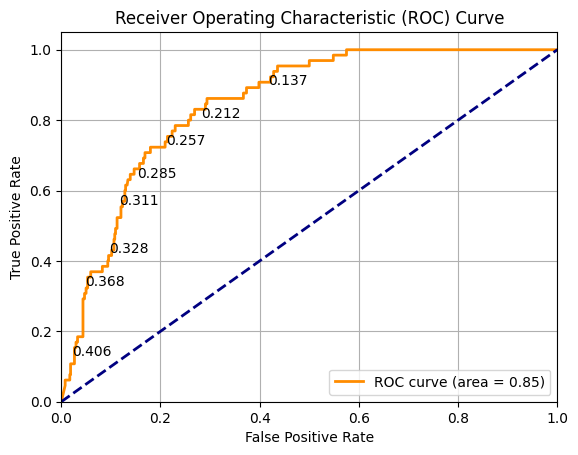

In [23]:
# Display ROC curve for training set if model is a network.
if clf_name == 'ShallowNetwork':
  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt

  y_pred_train = model.predict(X_train)

  # Compute the ROC curve values
  fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)

  # Compute the AUC (Area Under the Curve)
  roc_auc = auc(fpr, tpr)

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line

  # Select a subset of thresholds to annotate for clarity
  thresholds_to_display = np.linspace(0, len(thresholds) - 1, num=10, dtype=int)

  for i in thresholds_to_display[1:-1]:
      plt.annotate(f'{thresholds[i]:.3f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(10,-10), ha='center')

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

In [25]:
# Choose best threshold manually for neural network if cross-validation happened based on ROC AUC:
if clf_name == 'ShallowNetwork' and val_score == 'roc_auc':
  pos_threshold = 0.27

  best_params['pos_threshold'] = pos_threshold

In [26]:
  # Saving best hyperparameters.
  best_params_df = pd.DataFrame([best_params])

  params_output_path = os.path.join(output_dir, 'Parameters')

  os.makedirs(params_output_path, exist_ok=True)

  params_csv_path = os.path.join(output_dir, f'Parameters/params_{dataset_name}_{frame_selection_method}_{embedding_method}_{image_size}_{clf_name}_{val_score}.csv')

  best_params_df.to_csv(params_csv_path, index=False)

## Predictions and testing

## ROC curve

In [27]:
# Make predictions.
y_pred_raw = model.predict(X_test)

6/6 [==============================] - 0s 9ms/step


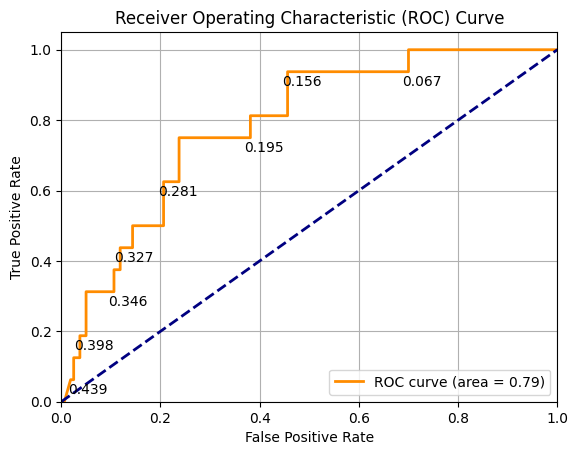

In [28]:
# Display ROC curve if model is a network.
if clf_name == 'ShallowNetwork':

  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt

  # Compute the ROC curve values
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_raw)

  # Compute the AUC (Area Under the Curve)
  roc_auc = auc(fpr, tpr)

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line

  # Select a subset of thresholds to annotate for clarity
  thresholds_to_display = np.linspace(0, len(thresholds) - 1, num=10, dtype=int)

  for i in thresholds_to_display[1:-1]:
      plt.annotate(f'{thresholds[i]:.3f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(10,-10), ha='center')

  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

## Save predictions for each instance of the test set.

In [29]:
# Prepare DataFrame with video names and predictions.
predictions_df = pd.DataFrame({
    'video': video_names_test,
    'prediction': y_pred_raw.squeeze()
})

# Create predictions output directory.
pred_output_path = os.path.join(output_dir, 'Predictions')
os.makedirs(params_output_path, exist_ok=True)

# Save predictions.
predictions_csv_path = os.path.join(output_dir, f'pred_{dataset_name}_{frame_selection_method}_{embedding_method}_{image_size}_{clf_name}_{val_score}.csv')
predictions_df.to_csv(predictions_csv_path, index=False)

In [30]:
# Copy prediction files to Drive.
for file in os.listdir(output_dir):
  source_dir = os.path.join(output_dir, file)

  if file.startswith('pred'):   # Only consider prediction outputs.
    dataset = file.split('_')[1]
    data_dir_name = dataset_dict[dataset]

    drive_output_dir = f"/content/drive/My Drive/UvA/M Thesis/Data/{data_dir_name}/Predictions"

    if not os.path.exists(drive_output_dir):
      os.makedirs(drive_output_dir)

    destination = f'{drive_output_dir}/{file}'

    shutil.copy(source_dir, destination)

for file in os.listdir(f'{output_dir}/Parameters'):
  source_dir = os.path.join(f'{output_dir}/Parameters', file)

  if file.startswith('params'):   # Only consider parameter outputs.
    dataset = file.split('_')[1]
    data_dir_name = dataset_dict[dataset]

    drive_output_dir = f"/content/drive/My Drive/UvA/M Thesis/Data/{data_dir_name}/Parameters"

    if not os.path.exists(drive_output_dir):
      os.makedirs(drive_output_dir)

    destination = f'{drive_output_dir}/{file}'

    shutil.copy(source_dir, destination)

## Classification report on the complete test set

In [31]:
# Turn sigmoid predictions into binary ones in case of a network.
if clf_name == 'ShallowNetwork':
  y_pred = (y_pred_raw > best_params['pos_threshold']).astype(int).squeeze()

else:
  y_pred = y_pred_raw

In [32]:
# Producing classification report.
report = classification_report(y_test, y_pred, target_names=['No attack', 'Attack'])

print(report)

              precision    recall  f1-score   support

   No attack       0.95      0.78      0.86       160
      Attack       0.22      0.62      0.32        16

    accuracy                           0.76       176
   macro avg       0.59      0.70      0.59       176
weighted avg       0.89      0.76      0.81       176

